# FWI with user provided misfit function

In this notebook, we will introduce how the loss (data misifit) can be modifed to a user chosen function for seismic inversion. We will use one of [JUDI](https://github.com/slimgroup/JUDI.jl)'s FWI example as a skeleton and illustrate the losses available in the package and how to input a custom data misfit function.


## Single source loss

In [JUDI](https://github.com/slimgroup/JUDI.jl), the data misfit function is defined on a single shot record basis (single source experiment) and will be automatically reduced by julia's distribution for multiple sources. Therefore, the misfit function is extremly simple and should have the form:

```julia

function misfit(dsyn, dobs)
    fval = ...
    adjoint_source = ...
    return fval, adjoint_source
end

```


Where `fval` is the misfit value for a given pair of synthetic `dsyn` and observed `dobs` shot records and `adjoint_source` is the residual to be backpropagated (adjoint wave-equation source) for the computation of the adjoint state gradient. For example the standard $\ell_2$ loss (default misfit in JUDI) is defined as

```julia

function mse(dsyn, dobs)
    fval = .5f0 * norm(dsyn - dobs)^2
    adjoint_source = syn - dobs
    return fval, adjoint_source
end

```

With this convention defined, we will now perform FWI with a few misfit functions and highlight the flexibility of this interface, including the possibility to use Julia's automatic differentiation frameworks to compute the adjoint souce of misfit functions difficult to differentiate by hand.


# Inversion setup

In [1]:
using SegyIO, HDF5, PythonPlot, JUDI, Random, LinearAlgebra, Printf, SlimPlotting, SlimOptim, Statistics

In [2]:
# Define some utilities for plotting
sx(d::judiVector) = d.geometry.xloc[1][1]

sx (generic function with 1 method)

We load the FWI starting model from the HDF5 model file and set up the JUDI model structure:

In [3]:
m0, n, d, o = read(h5open("overthrust_model.h5","r"),"m0","n","d","o")
model0 = Model((n[1],n[2]), (d[1],d[2]), (o[1],o[2]), copy(m0))

Model (n=(401, 121), d=(25.0f0, 25.0f0), o=(0.0f0, 0.0f0)) with parameters (:m, :rho)

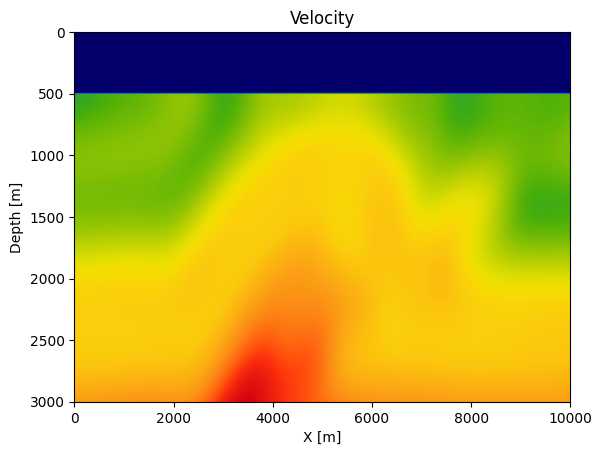

In [4]:
plot_velocity(m0'.^(-.5), d)

Then we read the SEG-Y file containing our test data set. The data was generated with a 2D excerpt from the Overthrust velocity model and consists of 31 shot records with 2 seconds recording time. We load the data and set up a JUDI seismic data vector:

In [5]:
block = segy_read("overthrust_shot_records.segy");
d_obs = judiVector(block);

┌ Warning: Fixed length trace flag set in stream: IOBuffer(data=UInt8[...], readable=true, writable=false, seekable=true, append=false, size=7076688, maxsize=Inf, ptr=3601, mark=-1)
└ @ SegyIO ~/.julia/dev/SegyIO/src/read/read_file.jl:36


Since the SEG-Y file contains the source coordinates, but not the wavelet itself, we create a JUDI `Geometry` structure for the source and then manually set up an 8 Hz Ricker wavelet. As for the observed data, we set up a JUDI seismic data vector `q` with the source geometry and wavelet:

In [6]:
src_geometry = Geometry(block; key="source");
src_data = ricker_wavelet(src_geometry.t[1], src_geometry.dt[1], 0.008f0);
q = judiVector(src_geometry, src_data);

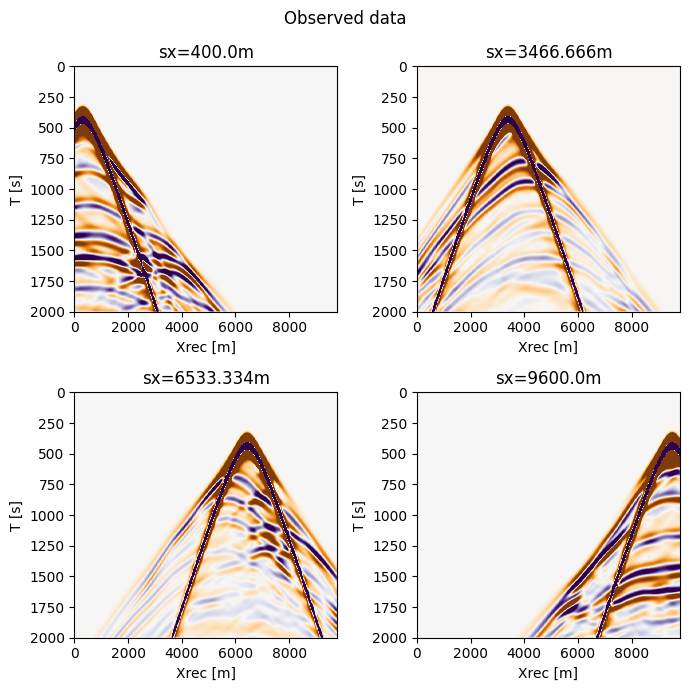

In [7]:
figure(figsize=(7, 7))
suptitle("Observed data")
subplot(221)
plot_sdata(d_obs[1]; new_fig=false, cmap="PuOr", name="sx=$(sx(q[1]))m")
subplot(222)
plot_sdata(d_obs[6]; new_fig=false, cmap="PuOr", name="sx=$(sx(q[6]))m")
subplot(223)
plot_sdata(d_obs[11]; new_fig=false, cmap="PuOr", name="sx=$(sx(q[11]))m")
subplot(224)
plot_sdata(d_obs[16]; new_fig=false, cmap="PuOr", name="sx=$(sx(q[16]))m")
tight_layout()

# Misfit functions

With the data and model defined, we can now define the misfit function we will be working with. For some of the considered functions, we will modify the observed data to highlight properties of a given misfit.

## Predefined misfit

JUDI provides two predefined misfits: the standard `mse` $\ell_2$ loss and the `studentst` misfit that correspond to the Student's T Loss that has been shown to increase robustness against outliers in the data. The Student's T loss is defined as 


```julia

function studentst(dsyn, dobs; k=2)
    fval = sum(.5 * (k + 1) * log.(1 .+ (dsyn - dobs).^2 ./ k)
    adjoint_source = (k + 1) .* (dsyn - dobs) ./ (k .+ (dsyn - dobs).^2)
    return fval, adjoint_source
end

```

where `k` is the number of degree of freedom (usually 1 or 2). We can see that in this case the adjoint source is pointwise normalized (in time and receiver position) which allows to mitigate outlier in the data such as incorrect amplitudes due to geophone mis-functionment. To illustrate this property, wee create an aritifical dataset with outliers to showcase the added robustness by artificially rescaling a few traces picked at random in every shot record of the dataset


In [8]:
d_outlier = deepcopy(d_obs)

## Add outliers to the data
for s=1:d_outlier.nsrc
    # Add noise
    nrec = d_outlier.geometry.nrec[s]
    inds = rand(1:nrec, 20)
    d_outlier.data[s][:, inds] .*= 10
end

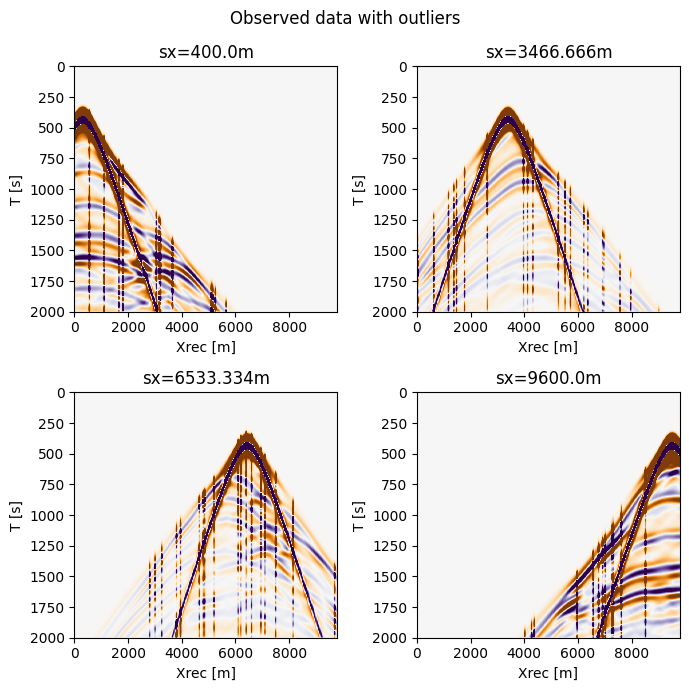

In [9]:
figure(figsize=(7, 7))
suptitle("Observed data with outliers")
subplot(221)
plot_sdata(d_outlier[1]; new_fig=false, cmap="PuOr", name="sx=$(sx(q[1]))m")
subplot(222)
plot_sdata(d_outlier[6]; new_fig=false, cmap="PuOr", name="sx=$(sx(q[6]))m")
subplot(223)
plot_sdata(d_outlier[11]; new_fig=false, cmap="PuOr", name="sx=$(sx(q[11]))m")
subplot(224)
plot_sdata(d_outlier[16]; new_fig=false, cmap="PuOr", name="sx=$(sx(q[16]))m")
tight_layout()

### Setup inversion

With the data and misfit functions defined, we can now run the inversion. For this example, we will use SlimOptim's spectral projected gradient, a simple gradient base optimization method were we impose bound constraints on the model. For practical considerations, we will also work with a stochastic objective function that only computes the gradient on a random subset of shots at each iteration. This method has been show to be efficient for seismic inversion in particualr with advanced algorithms with constraints or on simpler illustrative examples such as this one. We will use 8 shots per iteration (50% of the dataset) and run 20 iterations of the algorithm.

In [10]:
g_const = 0
function objective_function(x, d_obs, misfit=mse)
    model0.m .= reshape(x, model0.n);

    # fwi function value and gradient
    i = randperm(d_obs.nsrc)[1:batchsize]
    fval, grad = fwi_objective(model0, q[i], d_obs[i]; misfit=misfit)
    # Normalize for nicer convergence
    g = grad.data
    # Mute water
    g[:, 1:20] .= 0f0
    g_const == 0 && (global g_const = 1/norm(g, Inf))
    return fval, g_const .* g
end

objective_function (generic function with 2 methods)

In [11]:
# Bound constraints based on initial velocity
mmin = .95f0 * minimum(m0) * ones(Float32, n...)
mmax = 1.1f0 * maximum(m0) * ones(Float32, n...)

# Fix water layer
mmin[:, 1:20] .= m0[1,1]
mmax[:, 1:20] .= m0[1,1]

# Bound projection
proj(x) = reshape(median([vec(mmin) vec(x) vec(mmax)]; dims=2), model0.n)

proj (generic function with 1 method)

In [12]:
batchsize = 8
niter = 10

# Setup SPG
options = spg_options(verbose=3, maxIter=niter, memory=3)

# Compare l2 with students t on ideal data
ϕmse_ideal = x->objective_function(x, d_obs)
ϕst_ideal = x->objective_function(x, d_obs, studentst)

# Compare l2 with students t on the data with outliers
ϕmse_out = x->objective_function(x, d_outlier)
ϕst_out = x->objective_function(x, d_outlier, studentst)

#7 (generic function with 1 method)

In [13]:
# Perform the inversion
g_const = 0
solmse_ideal = spg(ϕmse_ideal, copy(m0), proj, options)
g_const = 0
solst_ideal = spg(ϕst_ideal, copy(m0), proj, options)
g_const = 0
solmse_out = spg(ϕmse_out, copy(m0), proj, options)
g_const = 0
solst_out = spg(ϕst_out, copy(m0), proj, options)

┌ Warning: Deprecated model.n, use size(model)
│   caller = ip:0x0
└ @ Core :-1
Building forward operator
Operator `forward` ran in 0.08 s
Building adjoint born operator
Operator `gradient` ran in 0.10 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.13 s
Operator `gradient` ran in 0.15 s


Running SPG...
Number of objective function to store: 3
Using  spectral projection : true
Maximum number of iterations: 10
SPG optimality tolerance: 1.00e-10
SPG progress tolerance: 1.00e-10
Line search: BackTracking{Float32, Int64}
 Iteration   FunEvals  GradEvals Projections     Step Length           alpha    Function Val        Opt Cond
         0          0          0          0     0.00000e+00     0.00000e+00     2.85864e+05     4.26022e-01
         1          2          2          6     1.00000e+00     4.44444e-02     1.94472e+05     4.20656e-01


Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.25 s
Operator `gradient` ran in 0.11 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.19 s
Operator `gradient` ran in 0.12 s


         2          4          4          9     1.00000e+00     3.01965e-02     2.82033e+05     4.51937e-01


Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.32 s
Operator `gradient` ran in 0.21 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.21 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.

         3          6          6         12     1.00000e+00     1.81715e-02     1.37834e+05     4.38780e-01


Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.12 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.20 s
Operator `gradient` ran in 0.12 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.12 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.19 s
Operator `gradient` ran in 0.18 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.

         4          8          8         15     1.00000e+00     2.18833e-02     9.92995e+04     4.25244e-01


Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.20 s
Operator `gradient` ran in 0.11 s
Operator `forward` ran in 0.20 s
Operator `gradient` ran in 0.12 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.

         5         10         10         18     1.00000e+00     1.64228e-02     6.89717e+04     4.15275e-01


Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.12 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.19 s
Operator `gradient` ran in 0.12 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.12 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.

         6         12         12         21     1.00000e+00     1.05933e-02     6.02415e+04     1.99492e-01


Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.

         7         14         14         24     1.00000e+00     8.04366e-03     4.98149e+04     4.05012e-01


Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.12 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.19 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.12 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.

         8         16         16         27     1.00000e+00     7.96887e-03     4.33893e+04     2.28679e-01


Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.12 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.

         9         18         18         30     1.00000e+00     1.03554e-02     3.89754e+04     4.11567e-01


Operator `forward` ran in 0.19 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.19 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.12 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.19 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.12 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.

        10         20         20         33     1.00000e+00     1.01486e-02     3.79055e+04     2.55810e-01
Running SPG...


Operator `forward` ran in 0.19 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.12 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.

Number of objective function to store: 3
Using  spectral projection : true
Maximum number of iterations: 10
SPG optimality tolerance: 1.00e-10
SPG progress tolerance: 1.00e-10
Line search: BackTracking{Float32, Int64}
 Iteration   FunEvals  GradEvals Projections     Step Length           alpha    Function Val        Opt Cond
         0          0          0          0     0.00000e+00     0.00000e+00     2.40584e+05     4.27019e-01
         1          2          2          6     1.00000e+00     4.44444e-02     2.15859e+05     4.21937e-01


Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.19 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.13 s


         2          5          5          9     1.00000e-01     2.95728e-02     1.63854e+05     4.15225e-01


Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.

         3          7          7         12     1.00000e+00     9.97828e-03     1.32403e+05     4.51937e-01


Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.21 s
Operator `gradient` ran in 0.12 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.13 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.

         4          9          9         15     1.00000e+00     6.52763e-03     1.22370e+05     4.14880e-01


Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.11 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.

         5         11         11         18     1.00000e+00     4.91783e-03     8.75994e+04     4.48727e-01


Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.19 s
Operator `gradient` ran in 0.12 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.

         6         13         13         21     1.00000e+00     4.80716e-03     8.33152e+04     4.17436e-01


Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.18 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.19 s
Operator `gradient` ran in 0.11 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.

         7         15         15         24     1.00000e+00     5.27185e-03     7.52859e+04     4.22962e-01


Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.19 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.13 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.

         8         17         17         27     1.00000e+00     7.61779e-03     7.96640e+04     3.93036e-01


Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.12 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.

         9         19         19         30     1.00000e+00     6.31348e-03     6.09902e+04     4.46877e-01


Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.12 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.12 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.

        10         21         21         33     1.00000e+00     3.74264e-03     5.56816e+04     3.77964e-01
Running SPG...


Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.12 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.

Number of objective function to store: 3
Using  spectral projection : true
Maximum number of iterations: 10
SPG optimality tolerance: 1.00e-10
SPG progress tolerance: 1.00e-10
Line search: BackTracking{Float32, Int64}
 Iteration   FunEvals  GradEvals Projections     Step Length           alpha    Function Val        Opt Cond
         0          0          0          0     0.00000e+00     0.00000e+00     7.79882e+07     4.12104e-01
         1          2          2          6     1.00000e+00     4.44444e-02     6.52109e+07     4.05440e-01


Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.12 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.15 s


         2          4          4          9     1.00000e+00     1.47441e-01     6.40722e+07     4.15491e-01


Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.19 s
Operator `gradient` ran in 0.10 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.25 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.

         3          6          6         12     1.00000e+00     3.67529e-01     6.01098e+07     4.25330e-01


Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.13 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.25 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.

         4          8          8         15     1.00000e+00     4.24748e-01     5.38629e+07     4.51937e-01


Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.12 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.19 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.

         5         11         11         18     1.00000e-01     3.36940e-01     5.60169e+07     4.51937e-01


Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.12 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.12 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.

         6         17         17         21     1.00000e-04     1.23082e-01     5.91505e+07     4.51937e-01


Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.11 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.19 s
Operator `gradient` ran in 0.12 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.21 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.19 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.19 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.12 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.

         7         22         22         24     1.00000e-03     2.48437e-05     5.73950e+07     4.41824e-01


Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.12 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.12 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.

         8         24         24         27     1.00000e+00     1.01067e-07     5.64525e+07     4.43751e-01


Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.12 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.20 s
Operator `gradient` ran in 0.12 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.

         9         27         27         30     1.00000e-01     4.47881e-07     5.51397e+07     4.51937e-01


Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.19 s
Operator `gradient` ran in 0.12 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.

        10         29         29         33     1.00000e+00     9.14351e-08     5.60286e+07     3.86250e-01
Running SPG...


Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.13 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.

Number of objective function to store: 3
Using  spectral projection : true
Maximum number of iterations: 10
SPG optimality tolerance: 1.00e-10
SPG progress tolerance: 1.00e-10
Line search: BackTracking{Float32, Int64}
 Iteration   FunEvals  GradEvals Projections     Step Length           alpha    Function Val        Opt Cond
         0          0          0          0     0.00000e+00     0.00000e+00     6.10253e+05     4.45547e-01
         1          2          2          6     1.00000e+00     4.44444e-02     6.00820e+05     4.14406e-01


Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.12 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.14 s


         2          6          6          9     1.00000e-02     3.00644e-02     5.57585e+05     4.21733e-01


Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.19 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.12 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.31 s
Operator `gradient` ran in 0.10 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.20 s
Operator `gradient` ran in 0.12 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.

         3         12         12         12     1.00000e-04     1.41513e-03     5.64038e+05     4.09358e-01


Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.19 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.12 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.12 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.20 s
Operator `gradient` ran in 0.12 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.12 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.

         4         15         15         15     1.00000e-01     1.00000e+00     5.66148e+05     4.51937e-01


Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.12 s
Operator `forward` ran in 0.19 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.12 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.

         5         20         20         18     1.00000e-03     2.46197e-02     5.52696e+05     4.51932e-01


Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.12 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.

         6         26         26         21     1.00000e-04     1.30046e-04     5.59800e+05     4.51923e-01


Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.24 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.22 s
Operator `gradient` ran in 0.11 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.

         7         29         29         24     1.00000e-01     3.49483e-08     5.31456e+05     4.51935e-01


Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.18 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.24 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.19 s
Operator `gradient` ran in 0.12 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.13 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.13 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.

         8         31         31         27     1.00000e+00     1.61415e-08     5.42866e+05     4.51928e-01


Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.19 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.13 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.21 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.19 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.22 s
Operator `gradient` ran in 0.

         9         35         35         30     1.00000e-02     1.01465e-07     5.08483e+05     4.47308e-01


Operator `forward` ran in 0.20 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.20 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.22 s
Operator `gradient` ran in 0.11 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.27 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.25 s
Operator `gradient` ran in 0.

        10         39         39         33     1.00000e-02     1.00000e+00     5.23507e+05     4.41755e-01


Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.20 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.19 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.12 s
Operator `forward` ran in 0.13 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.13 s
Operator `gradient` ran in 0.

result{Float32}(Float32[0.44444445 0.44444445 … 0.051429078 0.05002645; 0.44444445 0.44444445 … 0.051542435 0.049993496; … ; 0.44444445 0.44444445 … 0.0542229 0.05348921; 0.44444445 0.44444445 … 0.05424985 0.05341612], Float32[0.0 0.0 … -0.0011800642 -0.0011010842; 0.0 0.0 … -0.0010265235 -0.001206051; … ; 0.0 0.0 … 0.03403663 0.049344704; 0.0 0.0 … 0.035267144 0.04775219], 508483.1f0, Float32[610253.2, 600820.5, 557585.06, 564037.5, 566148.2, 552696.4, 559799.8, 531455.94, 542865.56, 508483.1, 523507.28], Matrix{Float32}[[0.44444445 0.44444445 … 0.05585606 0.05512348; 0.44444445 0.44444445 … 0.05584115 0.055107832; … ; 0.44444445 0.44444445 … 0.055858355 0.05516676; 0.44444445 0.44444445 … 0.05585274 0.05516145]], 33, 39, 39)

#### Results

We can now look at the inversion results for these two datasets and two misfit functions. We show all four results below. We can see that in the case of ideal data, we invert for the velocity fairly easily in both cases as expected and obtain an accurate reconstruction.

We obsereved on the second row that, as expected from the litterature, the student's t misift provides a very robust inversion in the presence of outlier and that the inverted velocity is as good as with ideal data. On the other hand, the standard `mse` misfits fails to lead to an acceptable inverted velocity in the presence of outliers as these outliers will lead to the main contribution to the gradient. These artifacts, once present in the velocity model after the few first iteration, cannot be recovered from.


┌ Warning: Deprecated model.d, use spacing(model)
│   caller = ip:0x0
└ @ Core :-1


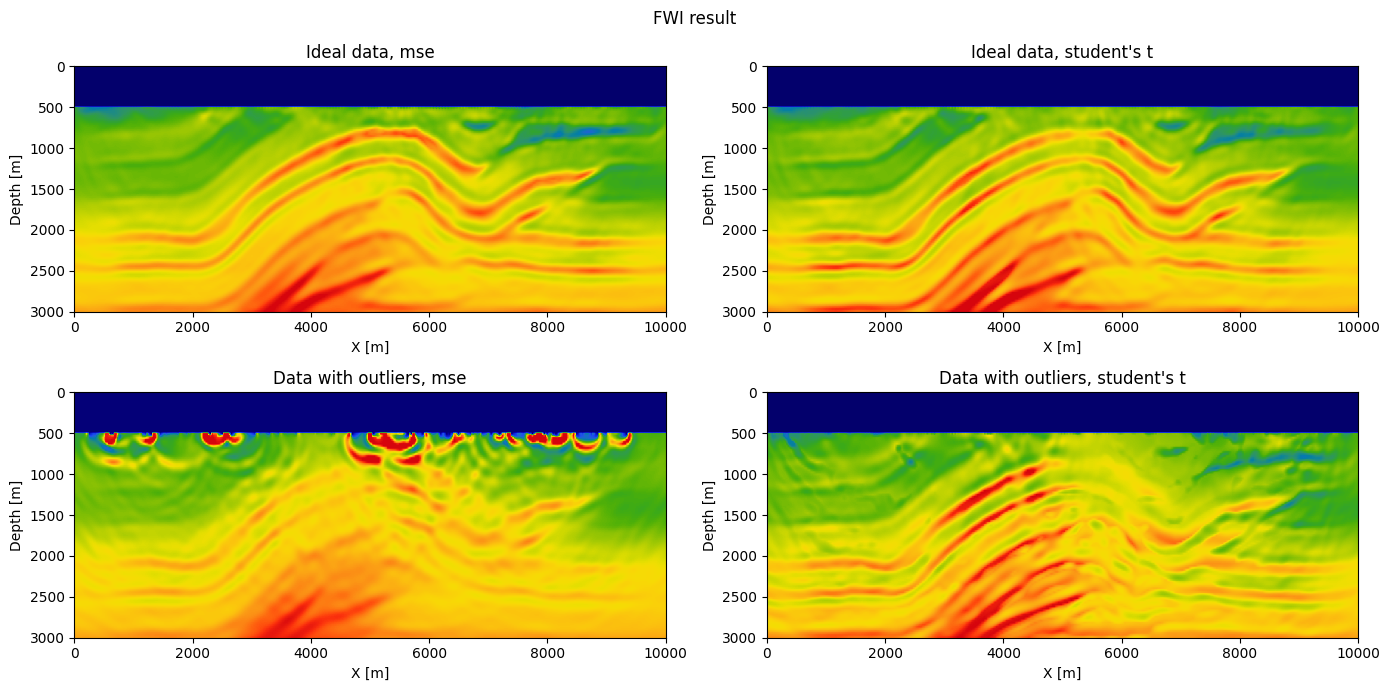

In [14]:
figure(figsize=(14, 7))
suptitle("FWI result")
subplot(221)
plot_velocity(reshape(solmse_ideal.x, model0.n)'.^(-.5), model0.d; new_fig=false, name="Ideal data, mse")
subplot(222)
plot_velocity(reshape(solst_ideal.x, model0.n)'.^(-.5), model0.d; new_fig=false, name="Ideal data, student's t")
subplot(223)
plot_velocity(reshape(solmse_out.x, model0.n)'.^(-.5), model0.d; new_fig=false, name="Data with outliers, mse")
subplot(224)
plot_velocity(reshape(solst_out.x, model0.n)'.^(-.5), model0.d; new_fig=false,  name="Data with outliers, student's t")
tight_layout()

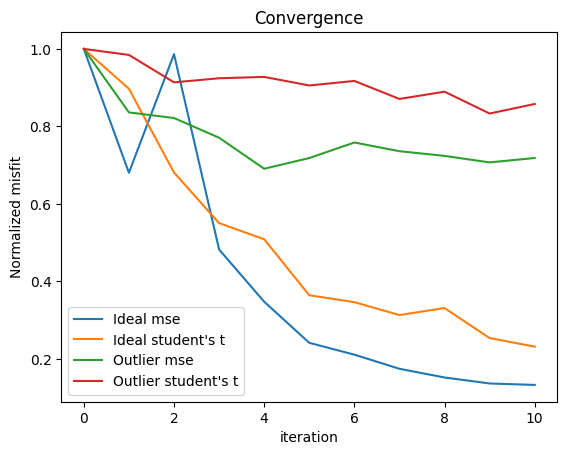

PyObject <matplotlib.legend.Legend object at 0x286aecbc0>

In [15]:
figure()
plot(solmse_ideal.ϕ_trace ./ solmse_ideal.ϕ_trace[1], label="Ideal mse")
plot(solst_ideal.ϕ_trace ./ solst_ideal.ϕ_trace[1], label="Ideal student's t")
plot(solmse_out.ϕ_trace ./ solmse_out.ϕ_trace[1], label="Outlier mse")
plot(solst_out.ϕ_trace ./ solst_out.ϕ_trace[1], label="Outlier student's t")
xlabel("iteration")
ylabel("Normalized misfit")
title("Convergence")
legend()

## Custom misfits

Finally, we now introduce how to use custom misfit for inversion. As illustrated above, the misfit is a simple keyword argument to the `fwi_objective/lsrtm_objective` function and consequently, any function returning the misfit value and adjoint source can be provided. In particular, users can take advantage of the extensive automatic differentiation ecosystem in Julia to define complicated misfit functions and automatically derive the corresponding adjoint source. 

In the following, as an illustrative example, we define the misfit for Envelope FWI and let Zygote computes its derivative with respect to the synthetic data. We add a little bit of complexity to the misfit function by normalizing the data by its $\ell_2$ norm as well to demonstrate how we can layer complexities in the misfit function and let the automatic differentiation infer the adjoint source.


In [16]:
using FFTW, Zygote

n2(x) = x / norm(x, 2)

function Hilbert(x)
    n = size(x, 1)
    σ = sign.(-n/2+1:n/2)
    y = imag(ifft(fftshift(σ.*fftshift(fft(x, 1), 1), 1), 1))
    return y
end

HLoss(dsyn, dobs) = sum(abs2.((dsyn - dobs) .+ 1im .* Hilbert(dsyn - dobs)))

function envelope(dsyn, dobs)
    ϕ = HLoss(n2(dsyn), n2(dobs))
    g = gradient(xs -> HLoss(n2(xs), n2(dobs)), dsyn)
    # Zygote always returns a tuple, in this case (g,)
    return ϕ, real.(g[1])
end

envelope (generic function with 1 method)

With our loss defined we can now rerun FWI with it

In [17]:
# Compare l2 with students t on ideal data
ϕh_ideal = x->objective_function(x, d_obs, envelope)

#11 (generic function with 1 method)

In [18]:
g_const = 0
solh_ideal = spg(ϕh_ideal, copy(m0), proj, options)

Running SPG...
Number of objective function to store: 3
Using  spectral projection : true
Maximum number of iterations: 10
SPG optimality tolerance: 1.00e-10
SPG progress tolerance: 1.00e-10
Line search: BackTracking{Float32, Int64}
 Iteration   FunEvals  GradEvals Projections     Step Length           alpha    Function Val        Opt Cond
         0          0          0          0     0.00000e+00     0.00000e+00     1.34861e+00     4.24539e-01


Operator `forward` ran in 0.35 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.12 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.12 s
Operator `forward` ran in 0.13 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.21 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.19 s
Operator `gradient` ran in 0.12 s


         1          2          2          6     1.00000e+00     4.44444e-02     9.53082e-01     4.16438e-01


Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.11 s
Operator `forward` ran in 0.13 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.16 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.18 s
Operator `forward` ran in 0.13 s
Operator `gradient` ran in 0.14 s


         2          5          5          9     4.98934e-01     2.96300e-02     6.69620e-01     4.50406e-01


Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.12 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.12 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.38 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.12 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.12 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.18 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.

         3          7          7         12     1.00000e+00     9.77559e-03     5.55584e-01     4.17551e-01


Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.12 s
Operator `forward` ran in 0.33 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.11 s
Operator `forward` ran in 0.13 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.13 s
Operator `gradient` ran in 0.18 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.

         4          9          9         15     1.00000e+00     8.47012e-03     3.44051e-01     3.27325e-01


Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.13 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.22 s
Operator `gradient` ran in 0.11 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.12 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.23 s
Operator `forward` ran in 0.21 s
Operator `gradient` ran in 0.11 s
Operator `forward` ran in 0.13 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.25 s
Operator `gradient` ran in 0.

         5         11         11         18     1.00000e+00     1.35786e-02     3.36199e-01     4.13840e-01


Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.12 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.20 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.13 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.20 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.13 s
Operator `gradient` ran in 0.12 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.20 s
Operator `gradient` ran in 0.

         6         13         13         21     1.00000e+00     1.80854e-02     2.53849e-01     2.15774e-01


Operator `forward` ran in 0.19 s
Operator `gradient` ran in 0.11 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.25 s
Operator `gradient` ran in 0.18 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.11 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.12 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.12 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.12 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.12 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.18 s
Operator `forward` ran in 0.26 s
Operator `gradient` ran in 0.11 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.

         7         15         15         24     1.00000e+00     1.90924e-02     2.16029e-01     4.39237e-01


Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.12 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.11 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.20 s
Operator `gradient` ran in 0.11 s
Operator `forward` ran in 0.19 s
Operator `gradient` ran in 0.11 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.12 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.11 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.12 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.12 s
Operator `forward` ran in 0.19 s
Operator `gradient` ran in 0.12 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.

         8         17         17         27     1.00000e+00     1.09404e-02     2.34752e-01     3.01672e-01


Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.12 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.12 s
Operator `forward` ran in 0.19 s
Operator `gradient` ran in 0.12 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.23 s
Operator `gradient` ran in 0.11 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.11 s
Operator `forward` ran in 0.19 s
Operator `gradient` ran in 0.11 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.12 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.17 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.12 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.

         9         19         19         30     1.00000e+00     6.24177e-03     2.04297e-01     4.30629e-01


Operator `forward` ran in 0.28 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.25 s
Operator `gradient` ran in 0.12 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.18 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.21 s
Operator `gradient` ran in 0.11 s
Operator `forward` ran in 0.19 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.21 s
Operator `gradient` ran in 0.12 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.12 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.11 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.12 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.

        10         21         21         33     1.00000e+00     4.97738e-03     1.71700e-01     2.29959e-01


Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.11 s
Operator `forward` ran in 0.19 s
Operator `gradient` ran in 0.12 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.12 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.12 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.14 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.13 s
Operator `forward` ran in 0.19 s
Operator `gradient` ran in 0.11 s
Operator `forward` ran in 0.15 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.16 s
Operator `gradient` ran in 0.14 s
Operator `forward` ran in 0.18 s
Operator `gradient` ran in 0.12 s
Operator `forward` ran in 0.17 s
Operator `gradient` ran in 0.

result{Float32}(Float32[0.44444445 0.44444445 … 0.052777432 0.051682685; 0.44444445 0.44444445 … 0.05279165 0.051519558; … ; 0.44444445 0.44444445 … 0.05390111 0.05265617; 0.44444445 0.44444445 … 0.053896144 0.052757252], Float32[0.0 0.0 … 0.026703982 0.026320018; 0.0 0.0 … 0.026807502 0.027489612; … ; 0.0 0.0 … 0.020523392 0.02911194; 0.0 0.0 … 0.02050988 0.027710995], 0.17170012f0, Float32[1.3486128, 0.95308167, 0.66962034, 0.5555845, 0.34405127, 0.3361993, 0.25384882, 0.21602856, 0.2347521, 0.20429665, 0.17170012], Matrix{Float32}[[0.44444445 0.44444445 … 0.05585606 0.05512348; 0.44444445 0.44444445 … 0.05584115 0.055107832; … ; 0.44444445 0.44444445 … 0.055858355 0.05516676; 0.44444445 0.44444445 … 0.05585274 0.05516145]], 33, 21, 21)

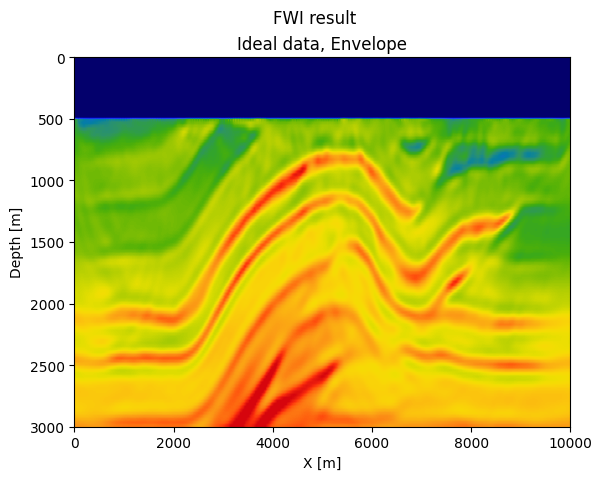

In [19]:
suptitle("FWI result")
plot_velocity(reshape(solh_ideal.x, model0.n)'.^(-.5), model0.d; new_fig=false, name="Ideal data, Envelope")

In this tutorial, we have seen how misfit functions can impact the inversion result and how JUDI provides multiple misfit functions and  a flexible interface for custom user inputs. This interface will allow for better application to real worl dataset since, as show in our example suite, JUDI already provide an interface for handling large SegY datasets and interfaces tricially with optimization frameworks